In [3]:
!pip install torch==2.2.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-geometric -f https://data.pyg.org/whl/torch-2.2.1+cpu.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.2.1+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.2.1+cpu.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.2.1+cpu.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.2.1+cpu.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 kB 2.7 MB/s eta 0:00:002.2 MB/s eta 0:00:01
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.3 MB/s eta 0:00:00 MB/s eta 0:00:010m:02
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.6/776.6 kB 982.1 kB/s eta 0:00:001m954.7 kB/s eta 0:00:01
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.8/215.8 kB 427.9 kB/s eta 0:00:00 kB/s eta 0:00:01:01


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx

/home/marius/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Node information and GCN embeddings:
Node: Event_0
Embedding: tensor([-2.3119e-01, -1.6862e-01,  4.4349e-02, -5.0699e-02, -2.8104e-01,
        -3.9275e-01,  8.4402e-02,  1.0447e-01,  1.9368e-01, -3.5476e-01,
        -3.1395e-01,  8.9203e-02, -6.6652e-01,  1.6511e-01, -4.1936e-01,
         5.4424e-02,  1.6919e-01,  4.2394e-02, -4.1758e-01, -9.3900e-02,
        -5.4258e-01, -7.2341e-01,  1.5994e-01, -3.9458e-01,  3.7100e-01,
        -7.0741e-02, -1.3362e-02, -4.5131e-01, -3.5793e-01,  1.0730e-01,
        -3.3780e-01,  2.1790e-01, -1.3532e-01, -1.6432e-01,  4.2228e-01,
         4.2277e-02,  4.9105e-02, -2.6514e-01,  3.0174e-01,  1.1747e-02,
        -5.4978e-01, -4.3286e-01,  3.5151e-02,  9.9232e-02, -4.9379e-01,
         1.5130e-01, -2.9885e+00, -1.4260e-01, -2.5316e-01, -4.6473e-01,
        -3.7551e-01,  2.0388e-01, -4.3185e-01,  5.8669e-01,  3.3895e-01,
        -2.8955e-01, -1.8356e-01, -6.4469e-01,  3.6594e-01, -5.2028e-01,
         5.2345e-01, -2.5164e-01,  1.9651e-01,  4.6049e-02, -9

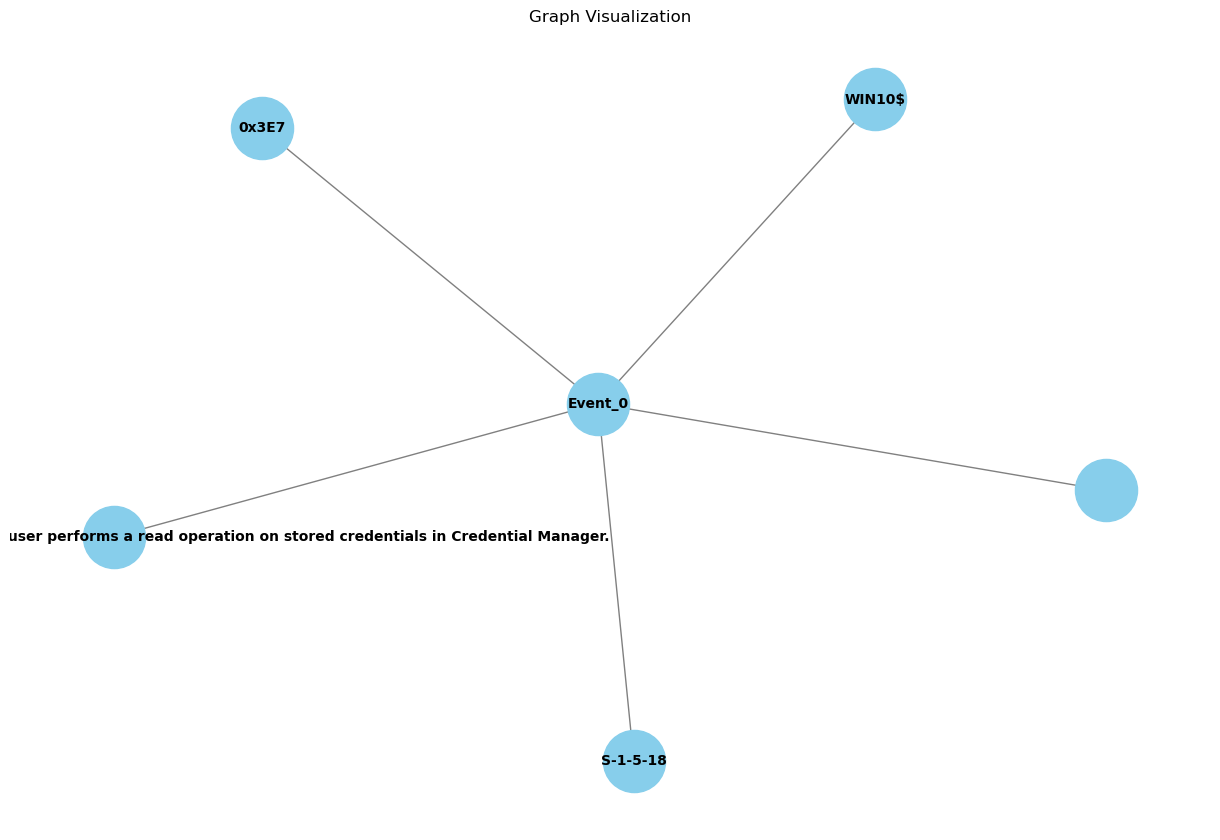

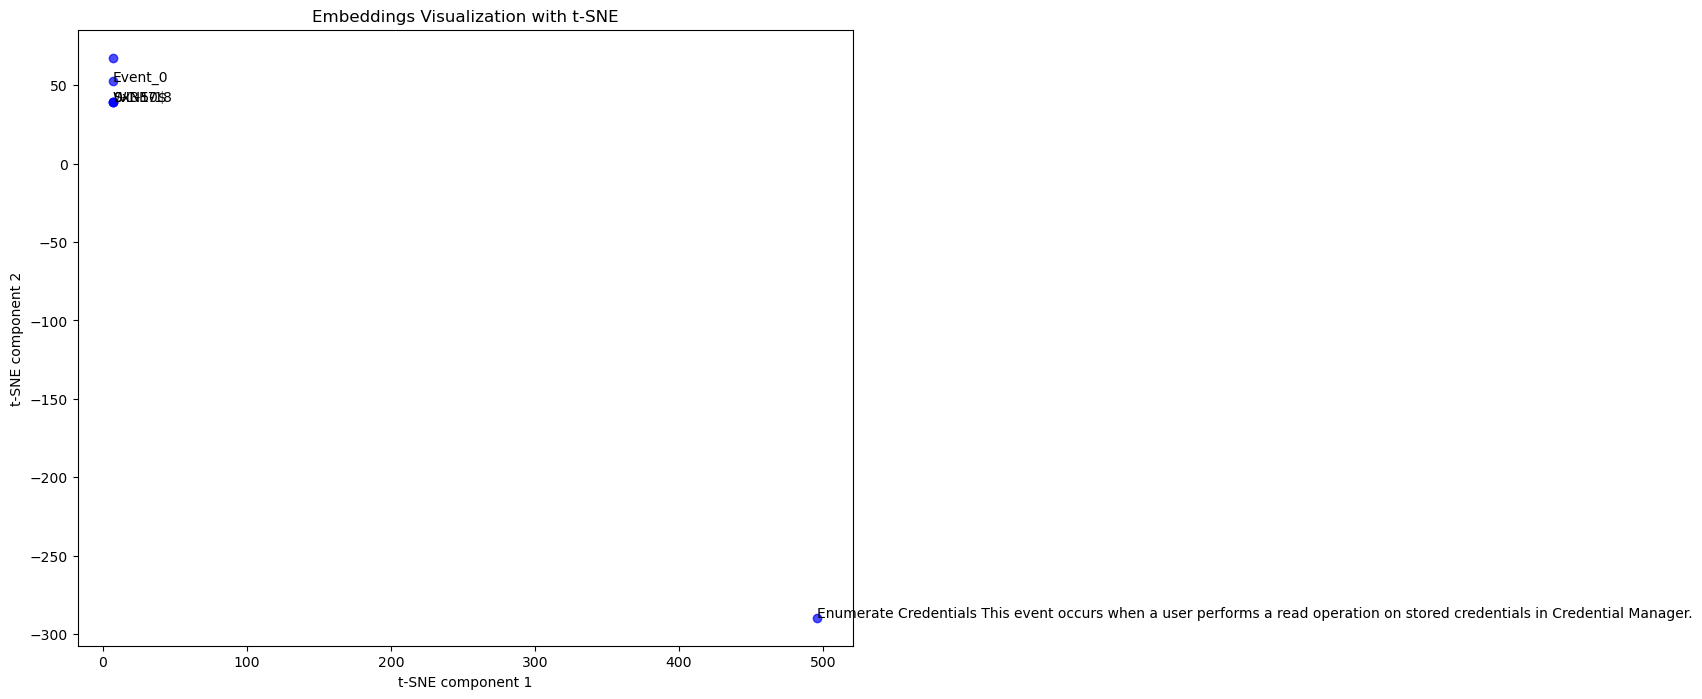

In [12]:
import pandas as pd
import torch
import torch.nn.functional as F
import networkx as nx
from transformers import BertTokenizer, BertModel
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Sample data
data = {
    "Timestamp": ["2024-05-15T16:00:15.887Z"],
    "OS": ["win10"],
    "IP": ["fe80::24b4:3691:44a6:38a1"],
    "LogLevel": ["information"],
    "EventID": [5379],
    "Category": ["User Account Management"],
    "Description": [
        """Credential Manager credentials were read.

        Subject:
                Security ID:            S-1-5-18
                Account Name:           WIN10$
                Account Domain:         sec699-20
                Logon ID:               0x3E7
                Read Operation:         Enumerate Credentials

        This event occurs when a user performs a read operation on stored credentials in Credential Manager."""
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)


# Reduce the data
def data_reduce(key):
    
    match(key):
        case "Account Domain":
            return None
       
        # If an exact match is not confirmed, this last case will be used if provided
        case _:
            return key



# Function to parse hierarchical data from description
def parse_description(description):
    hierarchy = {}
    lines = description.split('\n')
    key = None
    for line in lines:
        line = line.strip()
        if not line:
            continue
        if ':' in line:
            parts = line.split(':', 1)
            key = parts[0].strip()
            
            # Call data_reduce and skip the key if None is returned
            if data_reduce(key) is None:
                continue
            
            value = parts[1].strip()
            hierarchy[key] = value
        elif key:
            hierarchy[key] += ' ' + line.strip()
    return hierarchy

# Apply parsing to the Description column
df['ParsedDescription'] = df['Description'].apply(parse_description)

# Initialize graph
G = nx.Graph()

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Add nodes and edges to the graph
for index, row in df.iterrows():
    parsed = row['ParsedDescription']
    description = row['Description']
    
    # Tokenize and encode the description
    inputs = tokenizer(description, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    outputs = model(**inputs)
    description_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy().flatten()
    
    # Add event node with BERT embedding
    event_node = 'Event_{}'.format(index)
    G.add_node(event_node, type='event', embedding=description_embedding)
    
    # Add other nodes and connect to event node
    for key, value in parsed.items():
        if not G.has_node(value):
            G.add_node(value, type=key, embedding=torch.zeros(768).numpy())  # Add default embedding for non-event nodes
        G.add_edge(event_node, value)

# Convert NetworkX graph to PyTorch Geometric data
data = from_networkx(G)

# Add node features to the data object
node_embeddings = [G.nodes[node]['embedding'] for node in G.nodes]
data.x = torch.tensor(node_embeddings, dtype=torch.float)

# Define a simple GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 256)
        self.conv2 = GCNConv(256, 128)
        self.conv3 = GCNConv(128, 768)  # Output size matches the input embedding size

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

# Create and train the model
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.x)  # Dummy loss for example purposes
    loss.backward()
    optimizer.step()

# Extract the embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data)

# Print the embeddings and node information side by side
print("Node information and GCN embeddings:")
for i, node in enumerate(G.nodes):
    print(f"Node: {node}")
    print(f"Embedding: {embeddings[i]}\n")

# Visualize the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=2000, font_size=10, font_weight="bold")
plt.title("Graph Visualization")
plt.show()

# Visualize the embeddings using t-SNE
embeddings_np = embeddings.numpy()
tsne = TSNE(n_components=2, random_state=42, perplexity=1)  # Reduced perplexity to 1
embeddings_2d = tsne.fit_transform(embeddings_np)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='blue', alpha=0.7)
for i, node in enumerate(G.nodes):
    plt.annotate(node, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.title("Embeddings Visualization with t-SNE")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()
